In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
from iminuit import Minuit
from iminuit.cost import LeastSquares
import pickle

In [2]:
directory="/Users/ryan/arratia_lab/PTRG_Analysis"
os.chdir(directory)

# Dataframe Creation

In [3]:
#PTRIG

with open('Run9_list.txt') as f:
    lines = f.read().split('\n')
tags = None
IDs=[]
layers=[]
channels =[]
timeStamps = []
din={}
for line in lines:
    if line[:2]=="//" or len(line)==0:
        continue
    #first line after comments
    if tags is None:
        tags = line.split()
        tags=tags[-3:]
        continue;
#    print(line)
    split = line.split()
    layer, channel, LG, HG = split[0:4]
#    ID=f"{layer}-{channel}"
    ID=int(layer)*64+int(channel)
#    print(ID)
    if ID not in IDs:
        din[f"{ID}_LG"] = []
        din[f"{ID}_HG"] = []
        IDs.append(ID)
    din[f"{ID}_LG"].append(float(LG))
    din[f"{ID}_HG"].append(float(HG))
#print(din)

#making lists the same length
# maxlen=0
#print(din.values)
# for column in din.keys():
#     print(column)
#     if len(column)>maxlen:
#         maxlen=len(column)


#This says ptrig, but could be used for either ptrig or cosmic data. Just label which is which
ptrigDF = pd.DataFrame(din)



print(f"Done! Total events: {len(ptrigDF)}")
PTRIGpickle_file_name='./PTRIG_LG50_HG50_4k_R9.pkl'
ptrigDF.to_pickle(PTRIGpickle_file_name)



Done! Total events: 2176


# Analysis

### LG and HG Means per Channel

In [4]:
# Extracting HG columns
HG_columns = [col for col in ptrigDF.columns if 'HG' in col]
LG_columns = [col for col in ptrigDF.columns if 'LG' in col]


#sorting HG columns

# HG_columns= sorted(HG_columns, key=lambda x: int(x.split('_')[0]))
# LG_columns= sorted(LG_columns, key=lambda x: int(x.split('_')[0]))

#print(LG_columns)

# Creating HG_values list
HG_Ped_values = [np.array(ptrigDF[col].tolist()) for col in HG_columns]
LG_Ped_values = [np.array(ptrigDF[col].tolist()) for col in LG_columns]


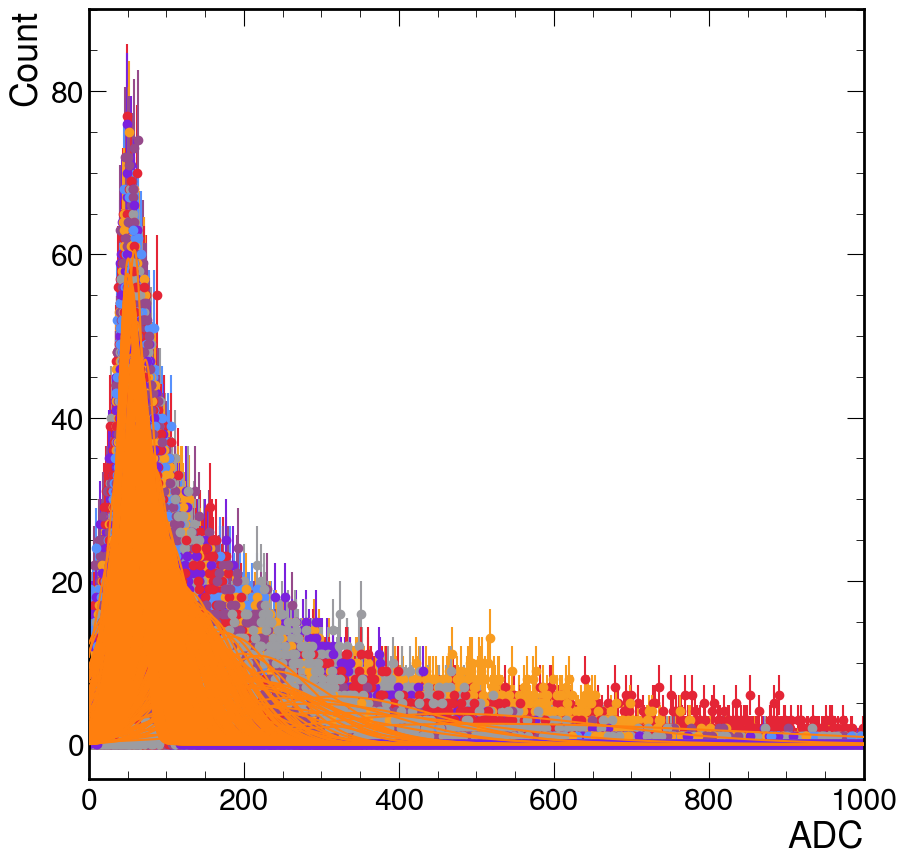

In [31]:
HGPeds = []
HGPedStd = []
errorlist=[]
problems=[]
num_channels = 25
start = 0

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['savefig.bbox'] = 'tight'
hep.style.use(hep.style.CMS)

def least_squares_loss(A, mu, sigma):
    y = gauss(bins, A, mu, sigma)
    return np.sum((data - y)**2)

#Defining the Gaussian function to fit to. 
#A is the amplitude, mu is the pedestal mean value, sigma is the pedestal standard deviation
def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

# Determine the grid size
num_cols = 5
num_rows = (num_channels + num_cols - 1) // num_cols
num_rows=5
# Create a figure and grid of subplots
# Plot histogram for each channel
#print(HG_Ped_values)
for i, HG_branch in enumerate(HG_Ped_values):
    HG_mask=np.array(HG_branch)<1000
    HG_branch_filtered=HG_branch[HG_mask]
    data = HG_branch_filtered
    bins = int(np.sqrt(len(data)))
    counts, bin_edges = np.histogram(data[data>0], bins=1000,range=[0,1000])
    #print(counts)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    errors = np.sqrt(counts)
    bin_centers = np.array(bin_centers)
    counts = np.array(counts)


    # Plot the histogram with error bars and the KDE
    plt.errorbar(bin_centers, counts, yerr=errors, fmt='o', label=f'Ch {i}')
    
    mask = (counts > 0)

    initial_params = [max(counts[mask]),np.mean(data),np.std(data)]
    m = Minuit(LeastSquares(bin_centers[mask], counts[mask], errors[mask], gauss), A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
    m.limits["sigma"] = (0, None)
    m.migrad()
    fitted_params = m.values
    errors = m.errors
    A_fit = fitted_params['A']
    mu_fit = fitted_params['mu']
    sigma_fit = fitted_params['sigma']
    x = np.linspace(0,1000, 1500)
    plt.xlim(0,1000)
    #plt.ylim(0,0.010)
    y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
    plt.plot(x, y_fit, color='tab:orange', zorder=101)
    HGPeds.append(mu_fit)
    HGPedStd.append(sigma_fit)

    errorlist.append(errors[1])


    #print(len(counts[mask]))
    #print(len(bin_centers[mask]))
          
#     handles, labels = plt.gca().get_legend_handles_labels()
#     plt.legend(handles[::-1], labels[::-1], fontsize=20)
    
    plt.ylabel('Count')
    plt.xlabel('ADC')
        


## Trouble Graphs HG

<ErrorView A=0.24673450143524803 mu=8.723446070575749 sigma=7.406323466799584>
<ValueView A=7.598016747765623 mu=68.09120668108157 sigma=116.336696255603>


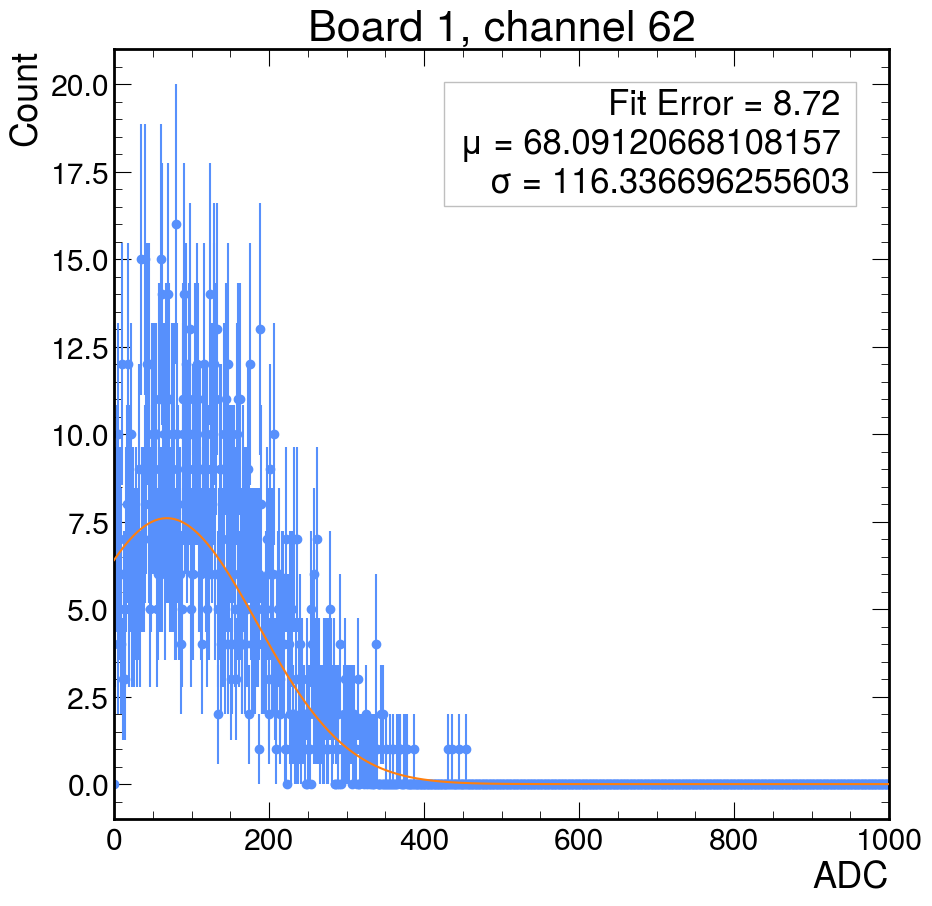

In [65]:
ID_num=126
singledata=HG_Ped_values[ID_num]
singledata=singledata[~np.isnan(singledata)]
singledata=singledata[singledata>0]
#bins = int(np.sqrt(len(singledata)))
counts, bin_edges = np.histogram(singledata, bins=1000, range=[0,1000])
#print(counts)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
errors = np.sqrt(counts)
bin_centers = np.array(bin_centers)
counts = np.array(counts)


plt.errorbar(bin_centers, counts, yerr=errors, fmt='o', label=f'Ch {i}')

# Plot the histogram with error bars and the KDE

mask = (counts > 0)

initial_params = [max(counts[mask]),np.mean(singledata),np.std(singledata)]
m = Minuit(LeastSquares(bin_centers[mask], counts[mask], errors[mask], gauss), A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
m.limits["sigma"] = (0, None)
m.migrad()
fitted_params = m.values
errors = m.errors
A_fit = fitted_params['A']
mu_fit = fitted_params['mu']
sigma_fit = fitted_params['sigma']
x = np.linspace(0,1000, 1500)
plt.xlim(0,1000)
y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
plt.plot(x, y_fit, color='tab:orange', zorder=101)

plt.ylabel('Count')
plt.xlabel('ADC')
plt.text(0.95, 0.95, f"Fit Error = {np.mean(errors[1]):.2f} \n \u03BC = {m.values[1]} \n \u03C3 = {m.values[2]}", 
         transform=plt.gca().transAxes,   # use axis coordinate system (0,0 bottom-left to 1,1 top-right)
         fontsize=25, 
         verticalalignment='top', 
         horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='gray'))

channel_num=ID_num%64
board_num=int((ID_num-channel_num)/64)
plt.title(f"Board {board_num}, channel {channel_num}")
print(errors)
print(m.values)

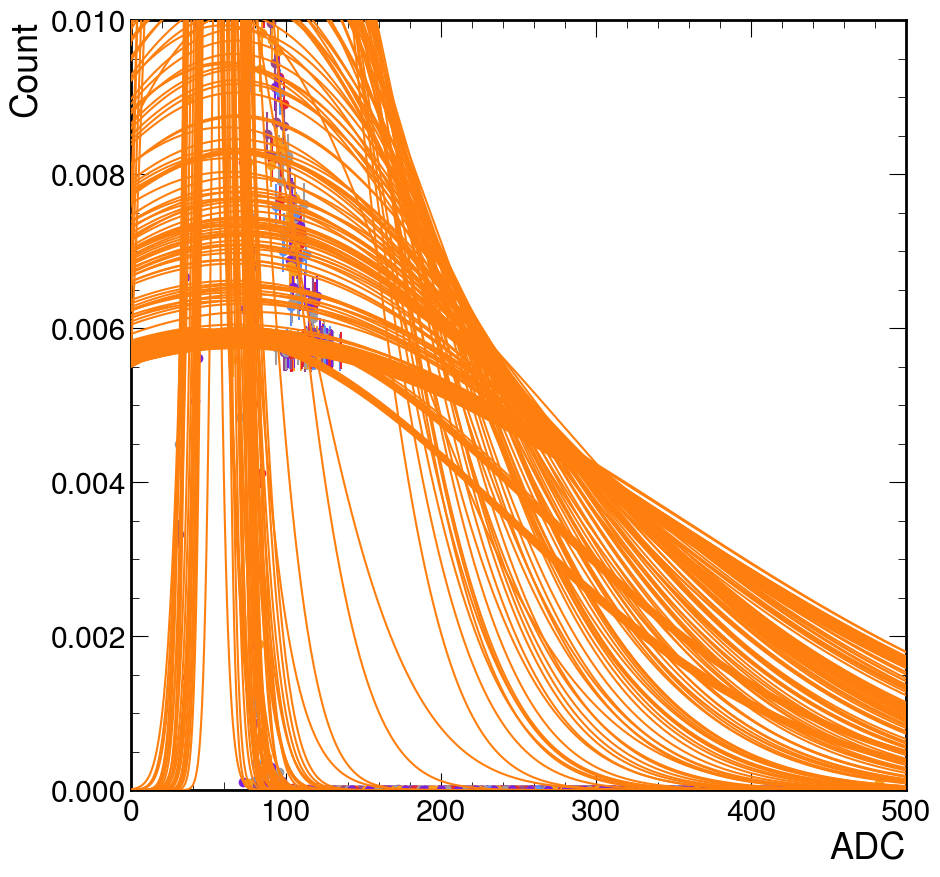

In [7]:
LGPeds = []
LGPedStd = []
num_channels = 25
start = 0

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['savefig.bbox'] = 'tight'
hep.style.use(hep.style.CMS)

def least_squares_loss(A, mu, sigma):
    y = gauss(bins, A, mu, sigma)
    return np.sum((data - y)**2)

#Defining the Gaussian function to fit to. 
#A is the amplitude, mu is the pedestal mean value, sigma is the pedestal standard deviation
def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

# Determine the grid size
num_cols = 5
num_rows = (num_channels + num_cols - 1) // num_cols
num_rows=5
# Create a figure and grid of subplots
# Plot histogram for each channel
#print(HG_Ped_values)
for i, LG_branch in enumerate(LG_Ped_values):
    data = LG_branch
    bins = int(np.sqrt(len(data)))
    counts, bin_edges = np.histogram(data, bins,density=True)
    #print(counts)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    errors = np.sqrt(counts * (len(data) / bins)) / len(data)
    bin_centers = np.array(bin_centers)
    counts = np.array(counts)


    # Plot the histogram with error bars and the KDE
    plt.errorbar(bin_centers, counts, yerr=errors, fmt='o', label=f'Ch {i}')
    
    mask = (counts > 0)

    initial_params = [max(counts[mask]),np.mean(data),np.std(data)]
    m = Minuit(LeastSquares(bin_centers[mask], counts[mask], errors[mask], gauss), A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
    m.limits["sigma"] = (0, None)
    m.migrad()
    fitted_params = m.values
    errors = m.errors
    A_fit = fitted_params['A']
    mu_fit = fitted_params['mu']
    sigma_fit = fitted_params['sigma']
    x = np.linspace(0,1000, 1500)
    plt.xlim(0,500)
    plt.ylim(0,0.010)
    y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
    plt.plot(x, y_fit, color='tab:orange', zorder=101)
    LGPeds.append(mu_fit)
    LGPedStd.append(sigma_fit)

    #print(len(counts[mask]))
    #print(len(bin_centers[mask]))
          
#     handles, labels = plt.gca().get_legend_handles_labels()
#     plt.legend(handles[::-1], labels[::-1], fontsize=20)
    
    plt.ylabel('Count')
    plt.xlabel('ADC')
        


In [9]:
din2={}
HG_IDs=[]
LG_IDs=[]
for i, HG_branch in enumerate(HG_Ped_values):
    name=HG_columns[i]
    #channelname=
    HG_mask=np.array(HG_branch)<1000
    HG_branch_filtered=HG_branch[HG_mask]
    if name not in HG_IDs:
        din2[name] = []
        HG_IDs.append(name)
    din2[name].append(f"mean:{np.mean(HG_branch_filtered)}")
    din2[name].append(f"std:{np.std(HG_branch_filtered)}")
for i, LG_branch in enumerate((LG_Ped_values)):
    name=LG_columns[i]
    LG_mask=np.array(LG_branch)<1000
    LG_branch_filtered=LG_branch[LG_mask]
    if name not in LG_IDs:
        din2[name] = []
        LG_IDs.append(name)
    din2[name].append(f"mean:{np.mean(LG_branch)}")
    din2[name].append(f"std:{np.std(LG_branch)}")
#print(din2)

ptrigDF2 = pd.DataFrame(din2)
PTRIGpickle_file_name2='./PTRIG_R9_with_vals.pkl'
ptrigDF2.to_pickle(PTRIGpickle_file_name2)



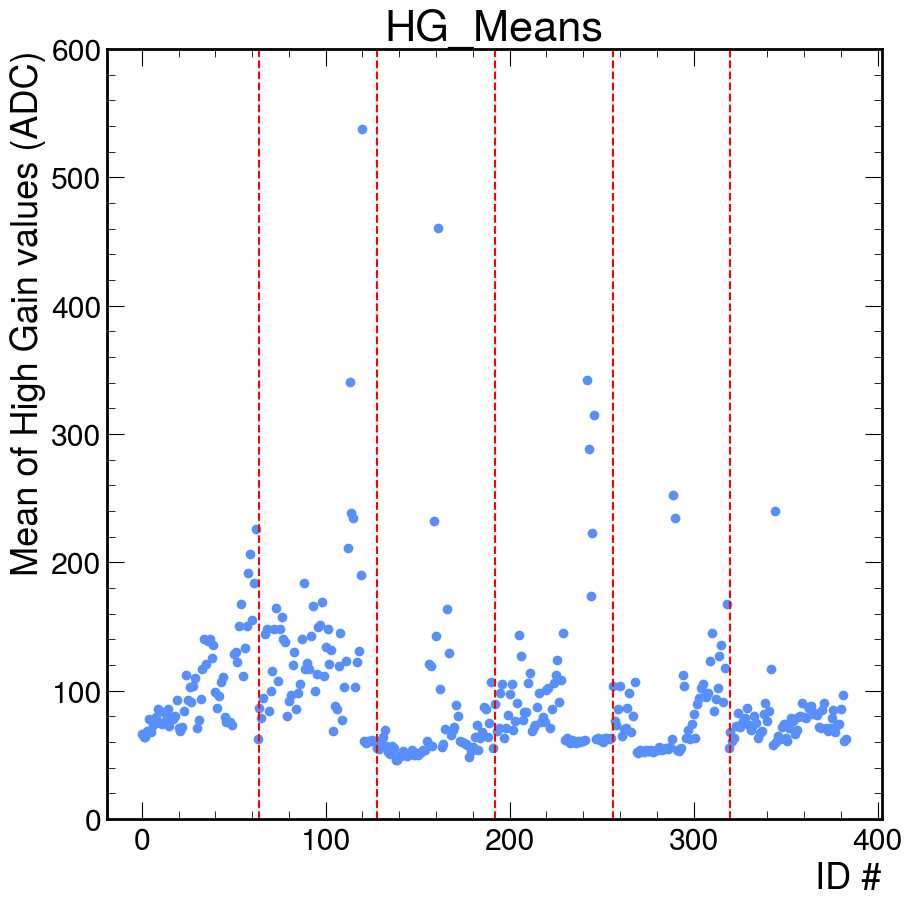

In [46]:
IDnums=[]
HG_means=[]
for ID in HG_IDs:
    IDnums.append(ID.split('_')[0])
    raw_mean=np.array(ptrigDF2[ID].tolist()[0])
    raw_meanstr=np.array2string(raw_mean)
    raw_meanstr=raw_meanstr[:-1]
    HG_means.append(raw_meanstr.split(':')[1])

plt.title('HG_Means')
plt.scatter(list(map(int,IDnums)),list(map(float,HG_means)))
plt.xlabel('ID #')
plt.ylabel('Mean of High Gain values (ADC)')
plt.ylim(0,600)

for i in range(1,6): #5 is number of caen units
    plt.axvline(x=i*64, color='red', linestyle='--')

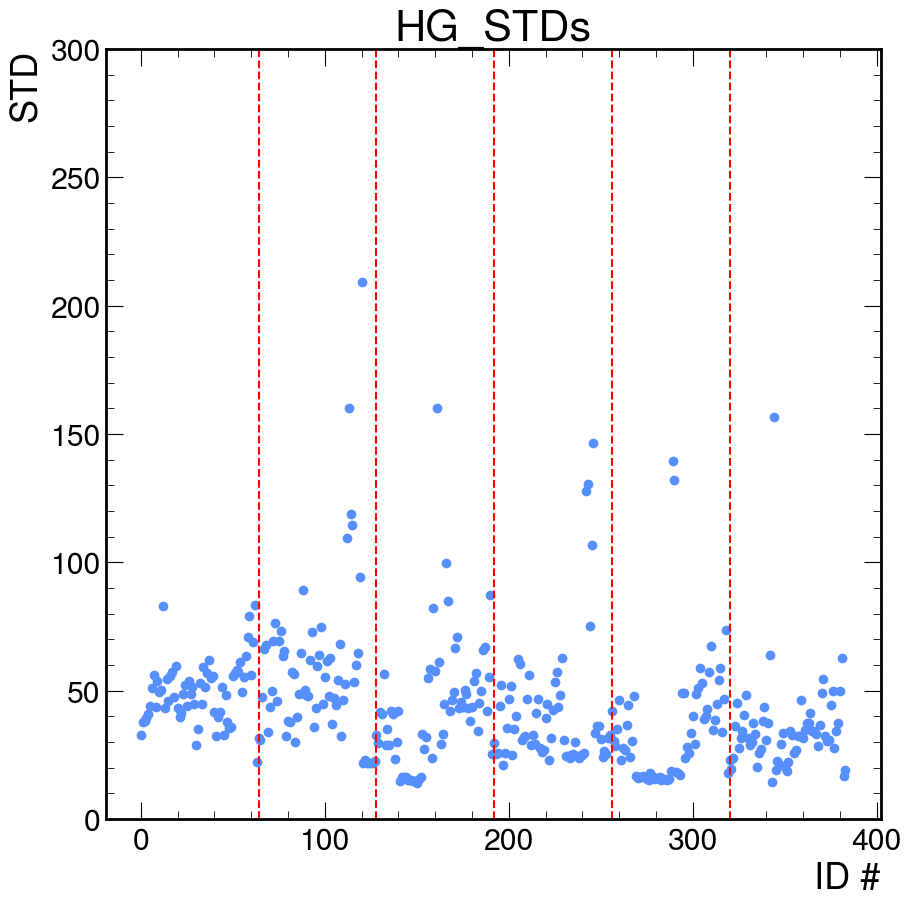

In [12]:
IDnums=[]
HG_stds=[]
for ID in HG_IDs:
    IDnums.append(ID.split('_')[0])
    raw_std=np.array(ptrigDF2[ID].tolist()[1])
    raw_stdstr=np.array2string(raw_std)
    raw_stdstr=raw_stdstr[:-1]
    HG_stds.append(raw_stdstr.split(':')[1])

plt.title('HG_STDs')
plt.xlabel('ID #')
plt.ylabel('STD')
plt.scatter(list(map(int,IDnums)),list(map(float,HG_stds)))
plt.ylim(0,300)
for i in range(1,6): #5 is number of caen units
    plt.axvline(x=i*64, color='red', linestyle='--')

56 14.08581452114303
126 8.727230232903917


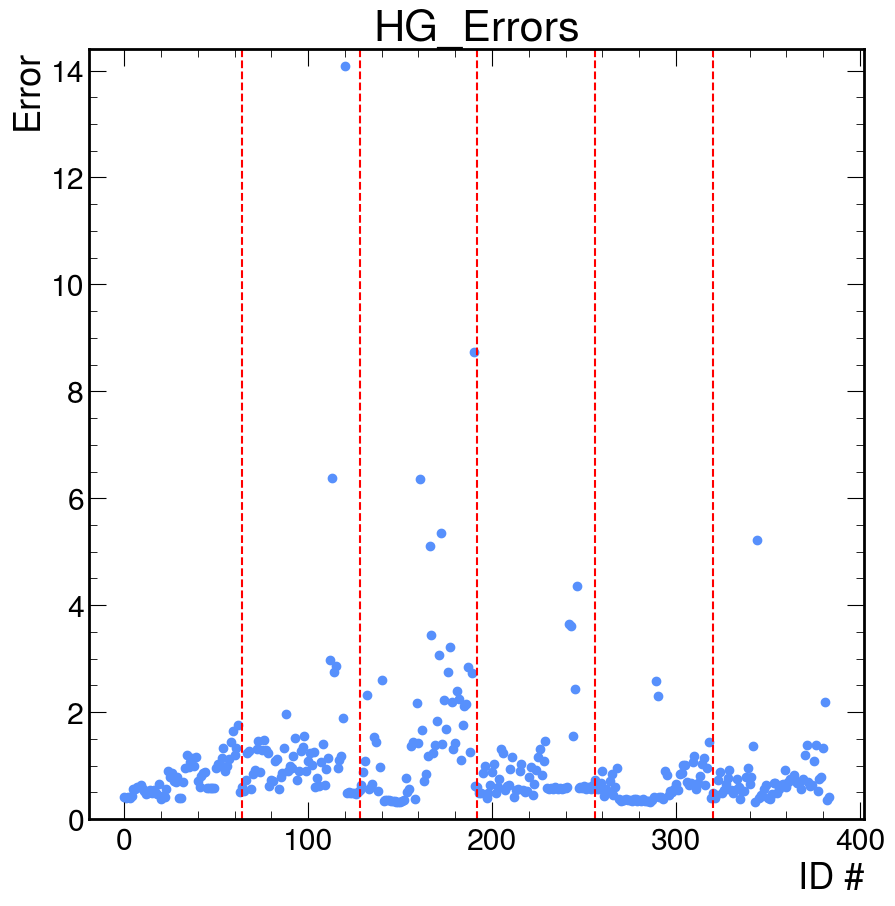

In [37]:
IDnums=[]
HG_errors=[]
for ID in HG_IDs:
    IDnums.append(ID.split('_')[0])
    
plt.title('HG_Errors')
plt.scatter(list(map(int,IDnums)),errorlist)
plt.xlabel('ID #')
plt.ylabel('Error')
plt.ylim(0,14.4)
for i in range(1,6): #5 is number of caen units
    plt.axvline(x=i*64, color='red', linestyle='--')

for i, mean in enumerate(errorlist):
    if mean>8:
        print(i, mean)


In [14]:
file_path = './PTRIG_R9_with_vals.pkl'

# Open the pickle file in read-binary mode ('rb')
with open(file_path, 'rb') as file:
    # Load the data from the pickle file
    data = pickle.load(file)

# Now you can use the loaded data
print(data)

                    64_HG                  65_HG                   66_HG  \
0  mean:86.89682174113312   mean:78.519115614924  mean:94.14173953060285   
1  std:31.781750033996016  std:30.79378191240724  std:47.602628946960714   

                    67_HG                    68_HG                   69_HG  \
0  mean:144.0091996320147  mean:148.15593376264948  mean:83.85694572217112   
1   std:66.25661625675939    std:67.96934390164904  std:33.787477131484344   

                     70_HG                    71_HG                    72_HG  \
0  mean:100.17219152854511  mean:115.42626728110599  mean:147.97791072250345   
1   std:43.634107751684354   std:49.763999270496726    std:69.43141288443371   

                   73_HG  ...                   54_LG                   55_LG  \
0            mean:164.25  ...  mean:60.17830882352941  mean:59.44439338235294   
1  std:76.45686096353806  ...   std:26.92494347187105  std:29.396325735159543   

                     56_LG                    57_LG